In [24]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import datetime
from collections import namedtuple

from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

from modular_baselines.loggers.basic import(InitLogCallback,
                                            LogRolloutCallback,
                                            LogWeightCallback,
                                            LogGradCallback,
                                            LogHyperparameters)

from modular_baselines.vca.algorithm import DiscerteStateVCA
from modular_baselines.vca.buffer import Buffer
from modular_baselines.vca.collector import NStepCollector
from modular_baselines.vca.modules import (CategoricalPolicyModule,
                                           FullCategoricalTransitionModule,
                                           CategoricalTransitionModule,
                                           MultiheadCatgoricalTransitionModule)
from environment import MazeEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
now = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
args = dict(
    buffer_size = 10000,
    policy_hidden_size = 64,
    policy_tau = 1,
    transition_hidden_size = 32,
    transition_module_tau = 1,
    batchsize = 32,
    entropy_coef = 0.025,
    rollout_len=10,
    total_timesteps=int(1e4),
    device="cpu",
    log_interval=95,
    trans_lr=3e-2,
    policy_lr=3e-3,
    use_gumbel=False,
    grad_norm=False,
    seed=None,
    log_dir="logs/{}".format(now)
)
if args["seed"] is None:
    args["seed"] = np.random.randint(0, 2**16)

In [26]:
args = namedtuple("Args", args.keys())(*args.values())
env = MazeEnv()

set_random_seed(args.seed)
vecenv = make_vec_env(lambda: MazeEnv(), seed=args.seed)

hyper_callback = LogHyperparameters(args._asdict())
rollout_callback = LogRolloutCallback()
init_callback = InitLogCallback(args.log_interval,
                                args.log_dir)
weight_callback = LogWeightCallback("weights.json")
grad_callback = LogGradCallback("grads.json")

buffer = Buffer(
    args.buffer_size,
    vecenv.observation_space,
    vecenv.action_space)

policy_m = CategoricalPolicyModule(
    vecenv.observation_space.n,
    vecenv.action_space.n,
    args.policy_hidden_size,
    tau=args.policy_tau,
    use_gumbel=args.use_gumbel)
trans_m = FullCategoricalTransitionModule(
    vecenv.observation_space.n,
    vecenv.action_space.n,
    state_set=torch.from_numpy(env.state_set),
    hidden_size=args.transition_hidden_size,
    tau=args.transition_module_tau,
    use_gumbel=args.use_gumbel)

collector = NStepCollector(
    env=vecenv,
    buffer=buffer,
    policy=policy_m,
    callbacks=[rollout_callback])
algorithm = DiscerteStateVCA(
    policy_module=policy_m,
    transition_module=trans_m,
    buffer=buffer,
    collector=collector,
    env=vecenv,
    reward_vals=env.expected_reward(),
    rollout_len=args.rollout_len,
    trans_opt=torch.optim.RMSprop(trans_m.parameters(), lr=args.trans_lr),
    policy_opt=torch.optim.RMSprop(policy_m.parameters(), lr=args.policy_lr),
    batch_size=args.batchsize,
    entropy_coef=args.entropy_coef,
    device=args.device,
    callbacks=[init_callback, weight_callback, grad_callback, hyper_callback]
)

Logging to logs/01-13-2021-18-04-29


/Users/tolga/anaconda/lib/python3.8/site-packages/pycolab/ascii_art.py:318: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



In [27]:
algorithm.learn(args.total_timesteps)

---------------------------------
| time/              |          |
|    fps             | 189      |
|    iterations      | 0        |
|    time_elapsed    | 0        |
|    total_timesteps | 10       |
| train/             |          |
|    Transition loss | 3.36     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 134      |
|    ep_rew_mean     | 0.714    |
| time/              |          |
|    fps             | 95       |
|    iterations      | 95       |
|    time_elapsed    | 10       |
|    total_timesteps | 960      |
| train/             |          |
|    E[R]            | 0.877    |
|    Transition loss | 1.48     |
|    entropy         | 159      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33       |
|    ep_rew_mean     | 0.931    |
| time/              |          |
|    fps             | 112      |
|    iteration

In [28]:
from visualizers.visualize import render_layout

render_layout(
    log_dir="logs/{}".format(now),
    layout=[["S", "S"], ["H", "H"]]
)

In [5]:
path = "static/policy_m2.b"
import os

os.makedirs("static", exist_ok=True)
with open(path, "wb") as bin_file:
    torch.save(algorithm.policy_module.state_dict(), bin_file)

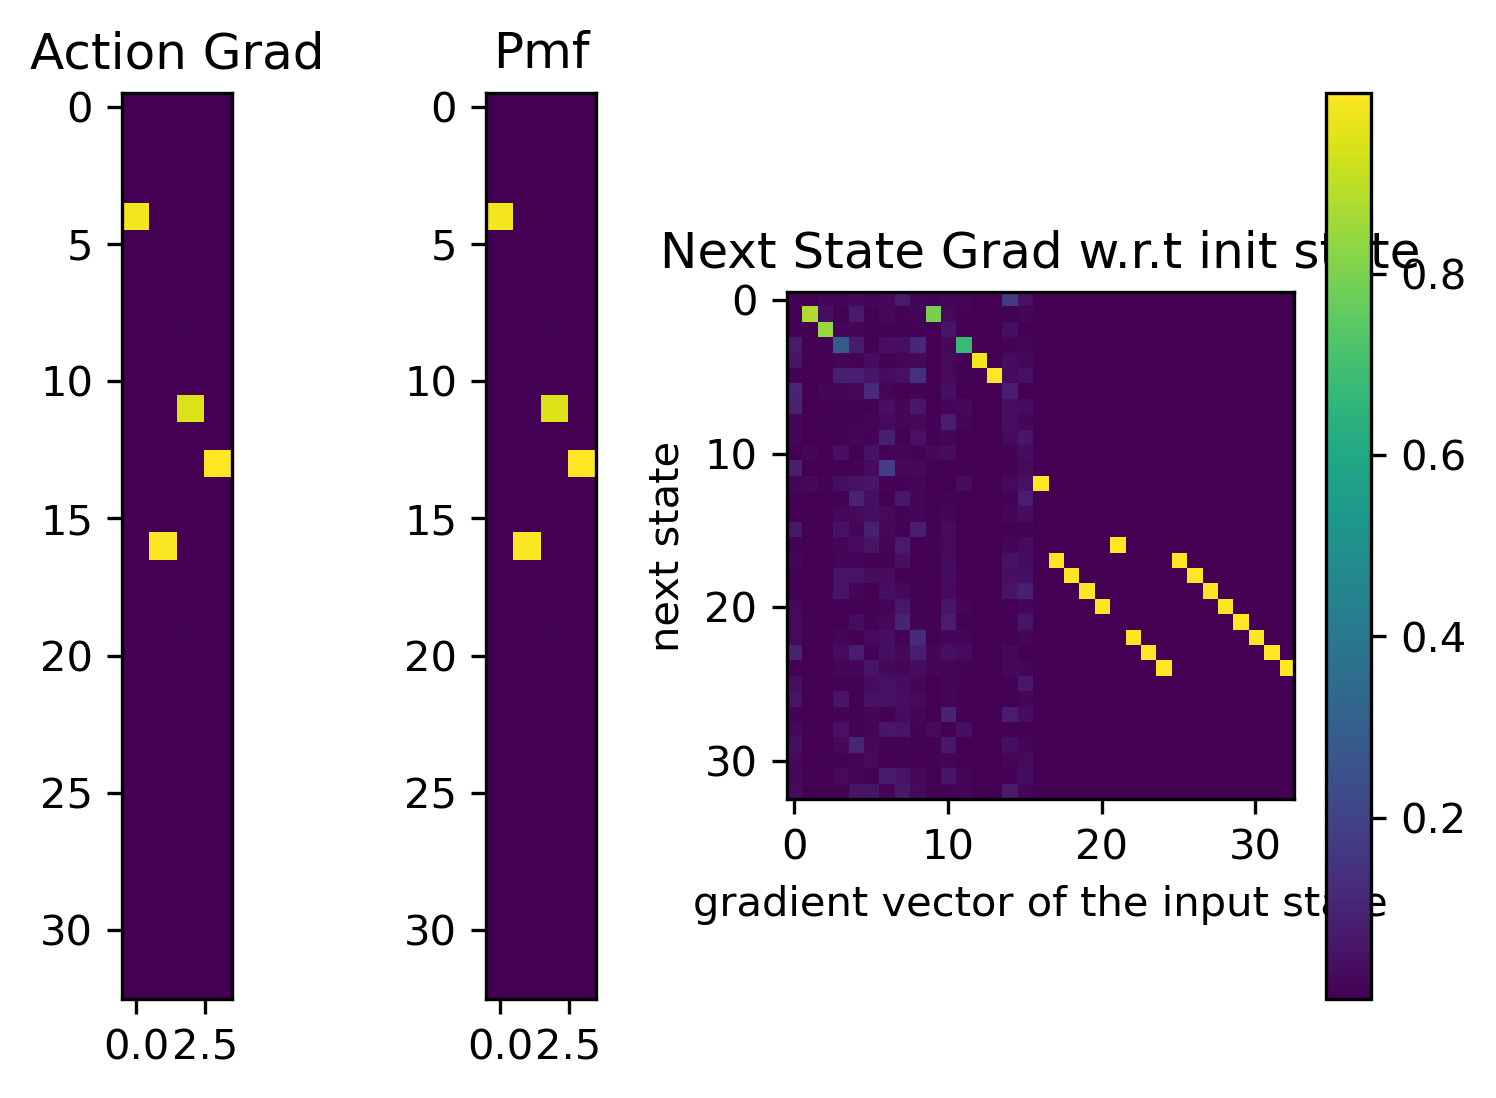

In [30]:
import matplotlib.pyplot as plt


def one_step_grad(init_state=12):
    jac_act = torch.zeros((4, env.observation_space.n, 4))
    jac_state = torch.zeros((4, env.observation_space.n, env.observation_space.n))
    
    r_state = (torch.ones((4, 1)) * init_state) == torch.arange(env.observation_space.n).reshape(1, -1)
    r_state = r_state.float()
    r_state.requires_grad = True
    r_state.retain_grad()
    
    action = torch.arange(4, requires_grad=False)
    r_action = algorithm._action_onehot(action.reshape(4, 1))
    r_action.requires_grad = True
    r_action.retain_grad()
    
    probs = algorithm.transition_module.dist(r_state, r_action)
    probs.retain_grad()

    for ix in range(env.observation_space.n):
        
        probs[:, ix].backward(torch.ones(4), retain_graph=True)
        jac_act[:, ix, :] = r_action.grad
        r_action.grad.zero_()
        
        jac_state[:, ix, :] = r_state.grad
        r_state.grad.zero_()
        
    return jac_act, jac_state, probs.detach().numpy().T

jax, jac_state, pmf = one_step_grad()

plt.figure(dpi=300)
plt.subplot(141)
plt.imshow(jax[0])
plt.title("Action Grad")
# plt.colorbar()

plt.subplot(142)
plt.imshow(pmf)
plt.title("Pmf")
# plt.colorbar()

plt.subplot(122)
plt.imshow(jac_state[0])
plt.title("Next State Grad w.r.t init state")
plt.ylabel("next state")
plt.xlabel("gradient vector of the input state")
plt.colorbar()


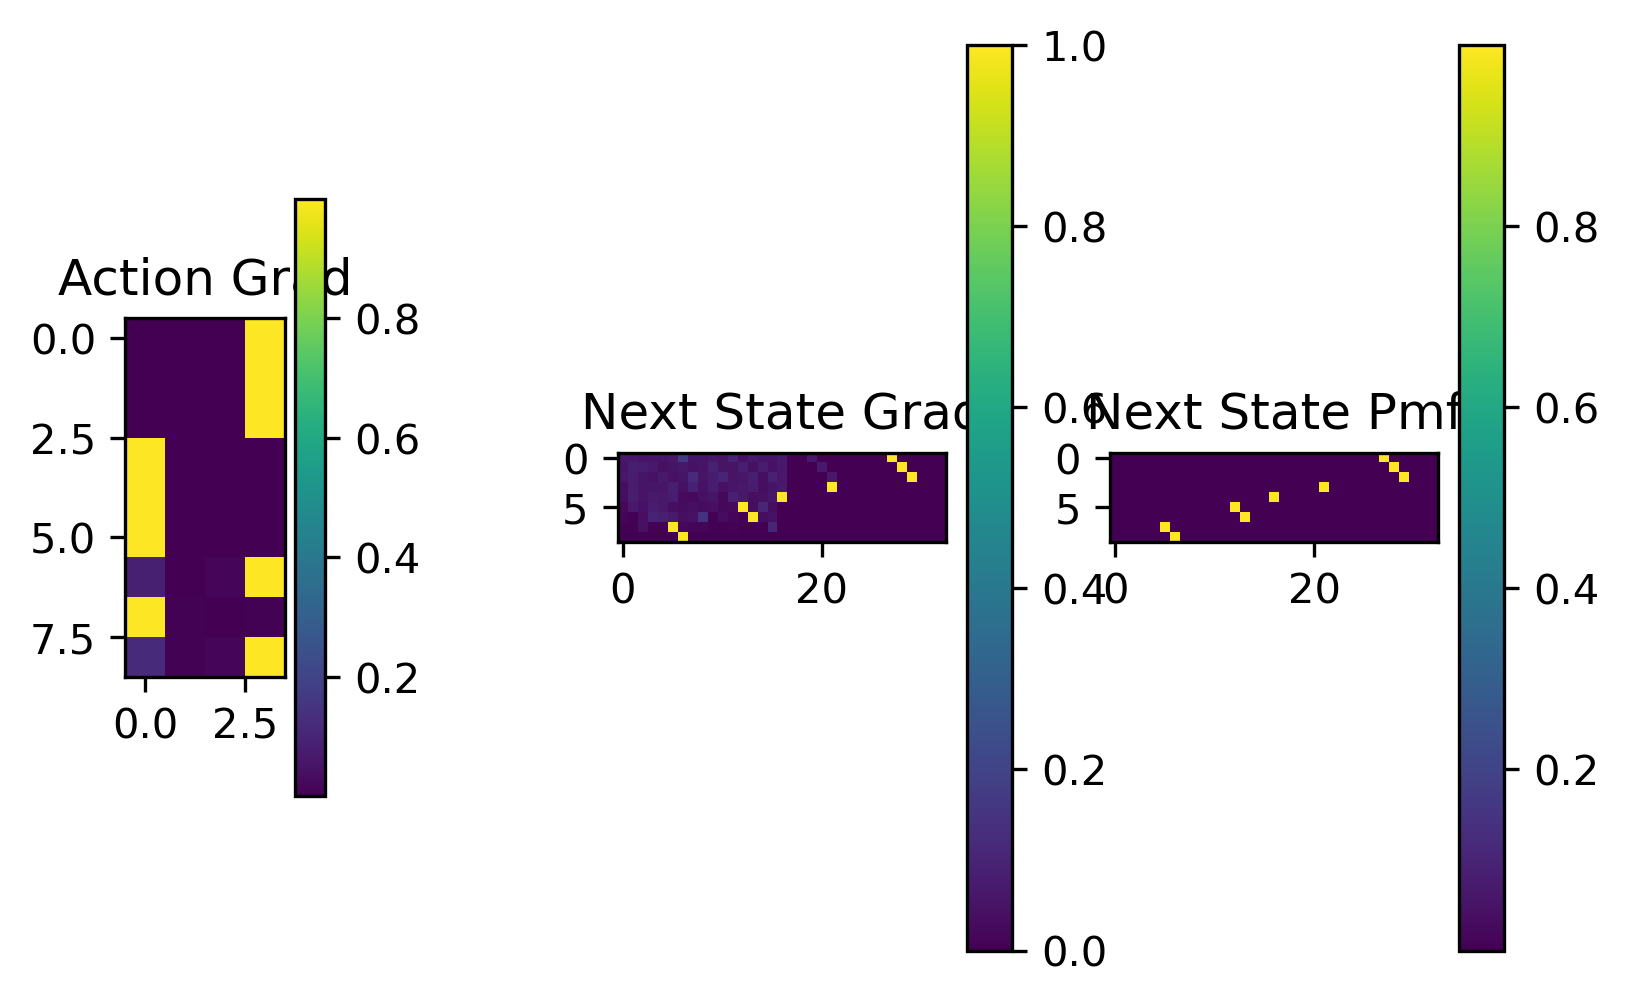

In [46]:
import matplotlib.pyplot as plt
from modular_baselines.vca.algorithm import GradNormalizer

def make_onehot_state(state):
    return ((torch.ones((1, 1)) * state) == torch.arange(env.observation_space.n).reshape(1, -1)).float()

def episode_grad(seed=12201, random_act=False):
    r_state_list = []
    r_action_list = []
    prob_list = []
    reward_list = []
    
    reward_tens = torch.from_numpy(env.expected_reward())
    done = False
    env.action_space.seed(seed)
    
    state = env.reset()
    r_state = make_onehot_state(state)
    r_state = r_state.float()
    r_state.requires_grad = True
    r_state.retain_grad()
    
    while not done:
        
        
        if random_act:
            action = env.action_space.sample()
            r_action = torch.tensor(action)
        else:
            action = algorithm.policy_module(r_state)
            r_action = action.detach()
        
        next_state, _, done, _ = env.step(r_action)
        next_state = make_onehot_state(next_state)
        
        r_action = (r_action.float().reshape(1, 1) == torch.arange(env.action_space.n).reshape(1, -1)).float()
        r_action.requires_grad = True
        r_action.retain_grad()
        r_action_list.append(r_action)
        
#         r_state = GradNormalizer.apply(r_state)
    
        probs = algorithm.transition_module.dist(r_state, r_action)
        prob_list.append(probs.detach())
        r_next_state = algorithm.transition_module.reparam(next_state, probs)
        r_next_state.retain_grad()
        r_state_list.append(r_next_state)

        reward_list.append((reward_tens * r_next_state).sum())
        r_state = r_next_state

#     sum(reward_list).backward()
    reward_list[-1].backward()
    return r_action_list, r_state_list, prob_list

actions, states, pmfs = episode_grad()
eps_acts_grad = torch.cat(list(map(lambda act: act.grad, actions)), dim=0)
eps_state_grad = torch.cat(list(map(lambda state: state.grad, states)), dim=0)
eps_pmfs = torch.cat(pmfs, dim=0)


plt.figure(dpi=300)
# print(eps_acts_grad)
plt.subplot(161)
plt.imshow(eps_acts_grad)
plt.title("Action Grad")
plt.colorbar()

# print(eps_acts_grad)
plt.subplot(132)
plt.imshow(eps_state_grad)
plt.title("Next State Grad")
plt.colorbar()

# print(eps_acts_grad)
plt.subplot(133)
plt.imshow(eps_pmfs)
plt.title("Next State Pmf")
plt.colorbar()

In [23]:
%load_ext autoreload
%autoreload 2

from visualizers.scalarvis import MultiScalarRender

MultiScalarRender("logs/01-12-2021-22-30-12/01-12-2021-22-30-12")()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
